# 超伝導
BCS理論におけるギャップ方程式を数値的に計算し、熱力学量(エントロピーおよび比熱)をJuliaで数値的に求める。
## ギャップ方程式の数値的な解
ギャップ方程式は非線形方程式である。Juliaでは[NLsolve.jl](https://github.com/JuliaNLSolvers/NLsolve.jl)を使って数値的に解くことができる。

使い方は、[非線形方程式を解くライブラリ(NLSolve package)](http://www.cas.cmc.osaka-u.ac.jp/~paoon/Lectures/2018-7Semester-AppliedMath9/04-nlsolve/)を参考にした。

In [1]:
using NLsolve
function nls(func, params...; ini = [0.0])
    if typeof(ini) <: Number
        r = nlsolve((vout,vin)->vout[1]=func(vin[1],params...), [ini])
        v = r.zero[1]
    else
        r = nlsolve((vout,vin)->vout .= func(vin,params...), ini)
        v = r.zero
    end
    return v, r.f_converged
end

nls (generic function with 1 method)

ギャップ方程式は
$\frac{1}{gV}=\int^{\hbar \omega_D}_0 d\xi \frac{\tanh(\frac{E_k}{2}\beta)}{E_k}$

ここで、$E_k=\sqrt{\xi^2+|\Delta|^2}$である。

[importコマンドの使用例(1) 超伝導ギャップと比熱](http://www.ss.scphys.kyoto-u.ac.jp/person/yonezawa/contents/program/gnuplot/import_example.html)を参考に、パラメータを$T_C$で割ることで無次元化する。数値積分は[QuadGk.jl](https://github.com/JuliaMath/QuadGK.jl)を用いて実行する。

In [2]:
using QuadGK
γ=0.5772
E_D=10^2
C=log(2*exp(γ)*E_D/π)

E(x::Float64,Δ::Float64)=sqrt(x^2+Δ^2)
IntegralFunctionDelta(x::Float64,Δ::Float64,T::Float64)=tanh(E(x,Δ)/(2T))/E(x,Δ)

function GapEquation(T::Float64)
    if T<1.0
        gapf(Δ::Float64,T::Float64)=quadgk(x->IntegralFunctionDelta(x,Δ,T),0,E_D)[1]-C
         return nls(gapf,T,ini=1.0)[1]
    else
        return 0.0
    end
end

GapEquation (generic function with 1 method)

今、解$\frac{\Delta}{k_BT_c}$が得られている。$\frac{\Delta}{\Delta_0}$とスケールするために

$\frac{\Delta}{\Delta_0}=\frac{k_B T_c}{\Delta_0}\frac{\Delta}{k_BT_c}=\frac{1.133}{2}\frac{\Delta}{k_BT_c}$

とスケールし直し、グラフを求める。

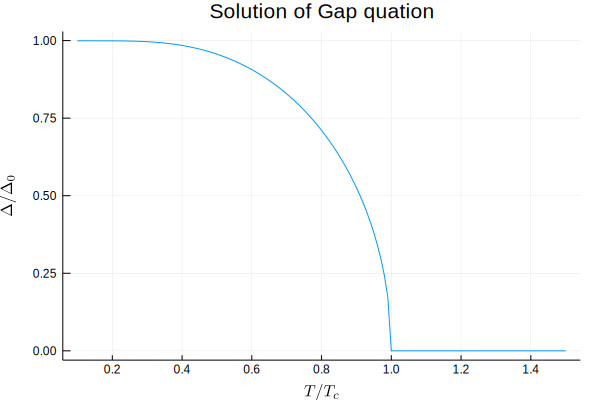

In [3]:
δt=0.01
t=[i for i in 0.1:δt:1.5]
delta=GapEquation.(t)

using Plots
plot(t,1.133/2 .*delta,label="",title="Solution of Gap quation ")
xaxis!("\$ T/T_c\$");yaxis!("\$\\Delta/ \\Delta_0\$")

# エントロピー
超伝導状態のエントロピーは、

$S(T)=-2k_BN(0)\int^{\hbar \omega_D}_{-\hbar \omega_D} d\xi \left[(1-f(E_k))\ln(1-f(E_k))+f(E_k)\ln(f(E_k)) \right]$

となる。

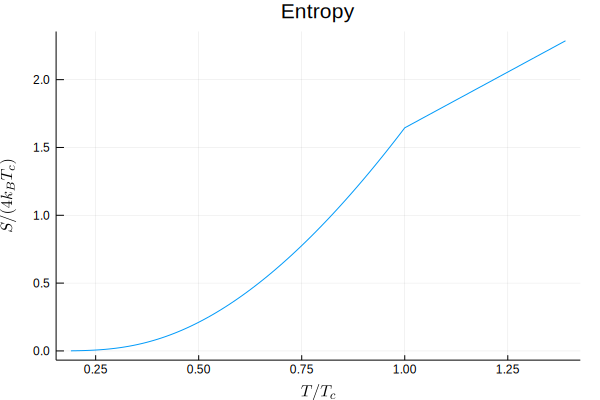

In [4]:
#フェルミ分布関数
f(x::Float64,T::Float64,Δ::Float64)=(1+exp(E(x,Δ)/T))^(-1)

IntegralFunctionS(x::Float64,T::Float64,Δ::Float64)=-(f(x,T,Δ)*log(f(x,T,Δ))+(1-f(x,T,Δ))*log(1-f(x,T,Δ)))
S(T::Float64,Δ::Float64)=quadgk(x->IntegralFunctionS(x,T,Δ),0,100)[1]
Entropy=S.(t[10:130],delta[10:130])

plot(t[10:130],Entropy,label="",title="Entropy")
xaxis!("\$ T/T_c\$");yaxis!("\$S/(4k_BT_c )\$")

## 比熱
比熱は、エントロピーから

$C_V=T\frac{\partial S}{\partial T}$

と計算される。

エントロピーの微分は数値微分で求めることができる。

ここでは、中心差分近似

$f'(x)=\frac{f(x+h)-f(x-h)}{2h}\hspace{5pt}(h:微小量)$

を用いて計算した。

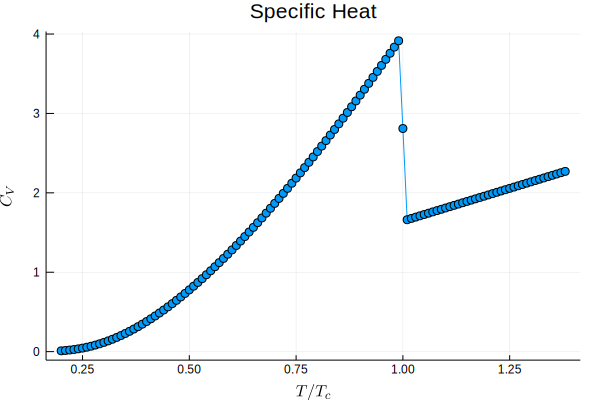

In [5]:
SpecificHeat=[ t[i]*(Entropy[i+1-9]-Entropy[i-1-9])/(2*δt) for i in 11:(130-1)]

plot(t[11:(130-1)],SpecificHeat,label="",marker=:circle,title="Specific Heat")
xaxis!("\$ T/T_c\$");yaxis!("\$C_V\$")

## Bogoliubov粒子のエネルギー$E(k)$

$E(k)=\sqrt{(\frac{\hbar k^2}{2m}-\mu)^2+\Delta^2}$

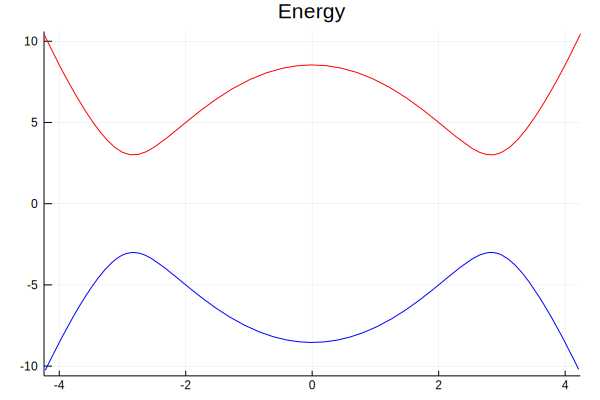

In [6]:
g(x) = sqrt((x^2-8.0)^2+3^2)
g(x,y)=sqrt((x^2+y^2-10.0)^2+3^2)

plot(x->g(x),xlim=[-4,4],ylims=[-10,10],label="",color=:red,title="Energy")
plot!(x->-g(x),label="",color=:blue)

$E(\tilde{k}_x,\tilde{k}_y)=\sqrt{(\tilde{k}_x^2+\tilde{k}_y^2-\mu)^2+\Delta^2}$

$\tilde{k_i}=\sqrt{\frac{\hbar}{2m}}k_i$

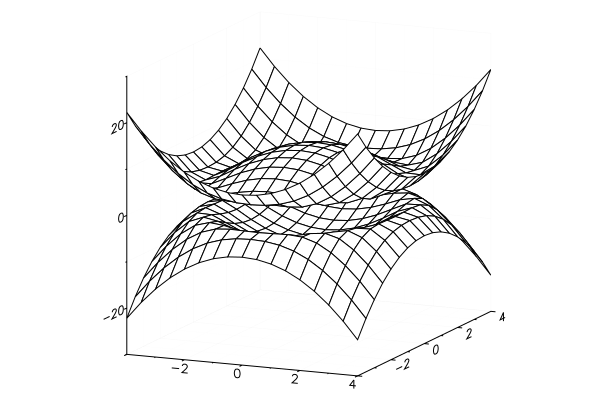

In [7]:
x = -4.0:0.5:4.0
y = -4.0:0.5:4.0
z = [g(i,j) for i in x, j in y]'

plot(x,y,-z, st=:wireframe)
plot!(x,y,z, st=:wireframe)

BCS状態は、次のように$|0>$と$c^\dagger_{k,\uparrow}c_{-k,\downarrow}|0>$の線形結合で定義される。

$|\text{BCS}>=\Pi_k \left(u_k+v_kc^\dagger_{k,\uparrow}c_{-k,\downarrow}\right)|0>$

それぞれの係数は、Bogoliubov変換で対角化するときに固有ベクトルを計算することにより得られる。

$u_k=\sqrt{\frac{1}{2}(1+\frac{\xi}{E_k})}$

$v_k=\sqrt{\frac{1}{2}(1-\frac{\xi}{E_k})}$

$\Delta$が十分小さい場合、各係数は以下のグラフのようになる。

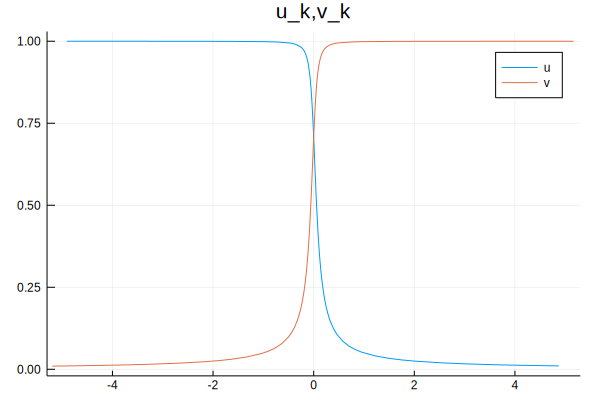

In [8]:
u(x::Float64,Δ::Float64)=sqrt(0.5*(1-x/E(x,Δ)))
v(x::Float64,Δ::Float64)=sqrt(0.5*(1+x/E(x,Δ)))

plot(x->u(x,0.1),xlim=[-5,5],label="u",title="u_k,v_k")
plot!(x->v(x,0.1),xlim=[-5,5],label="v")

## 状態密度
$g(i\omega)=-\pi N(0)\frac{i \omega \textbf{1}-\textbf{$\Delta$}}{\sqrt{\omega^2+|\Delta|^2}}$

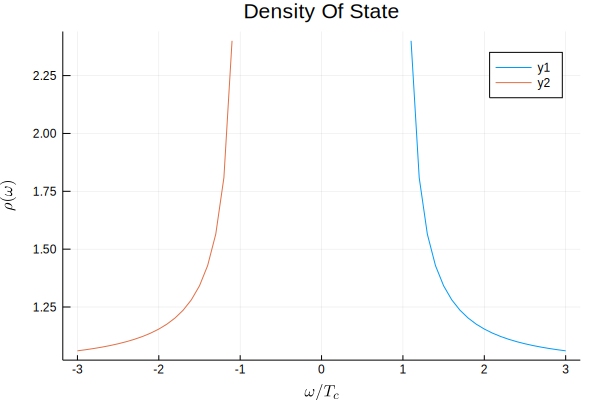

In [9]:
x1=1.1:0.1:3.0
x2=-3.0:0.1:-1.1
rho(x)=abs(x)/sqrt(x^2-1.0^2)
plot([x1,x2],[rho.(x1),rho.(x2)],title="Density Of State")
xaxis!("\$ \\omega/T_c\$");yaxis!("\$\\rho (\\omega)\$")